
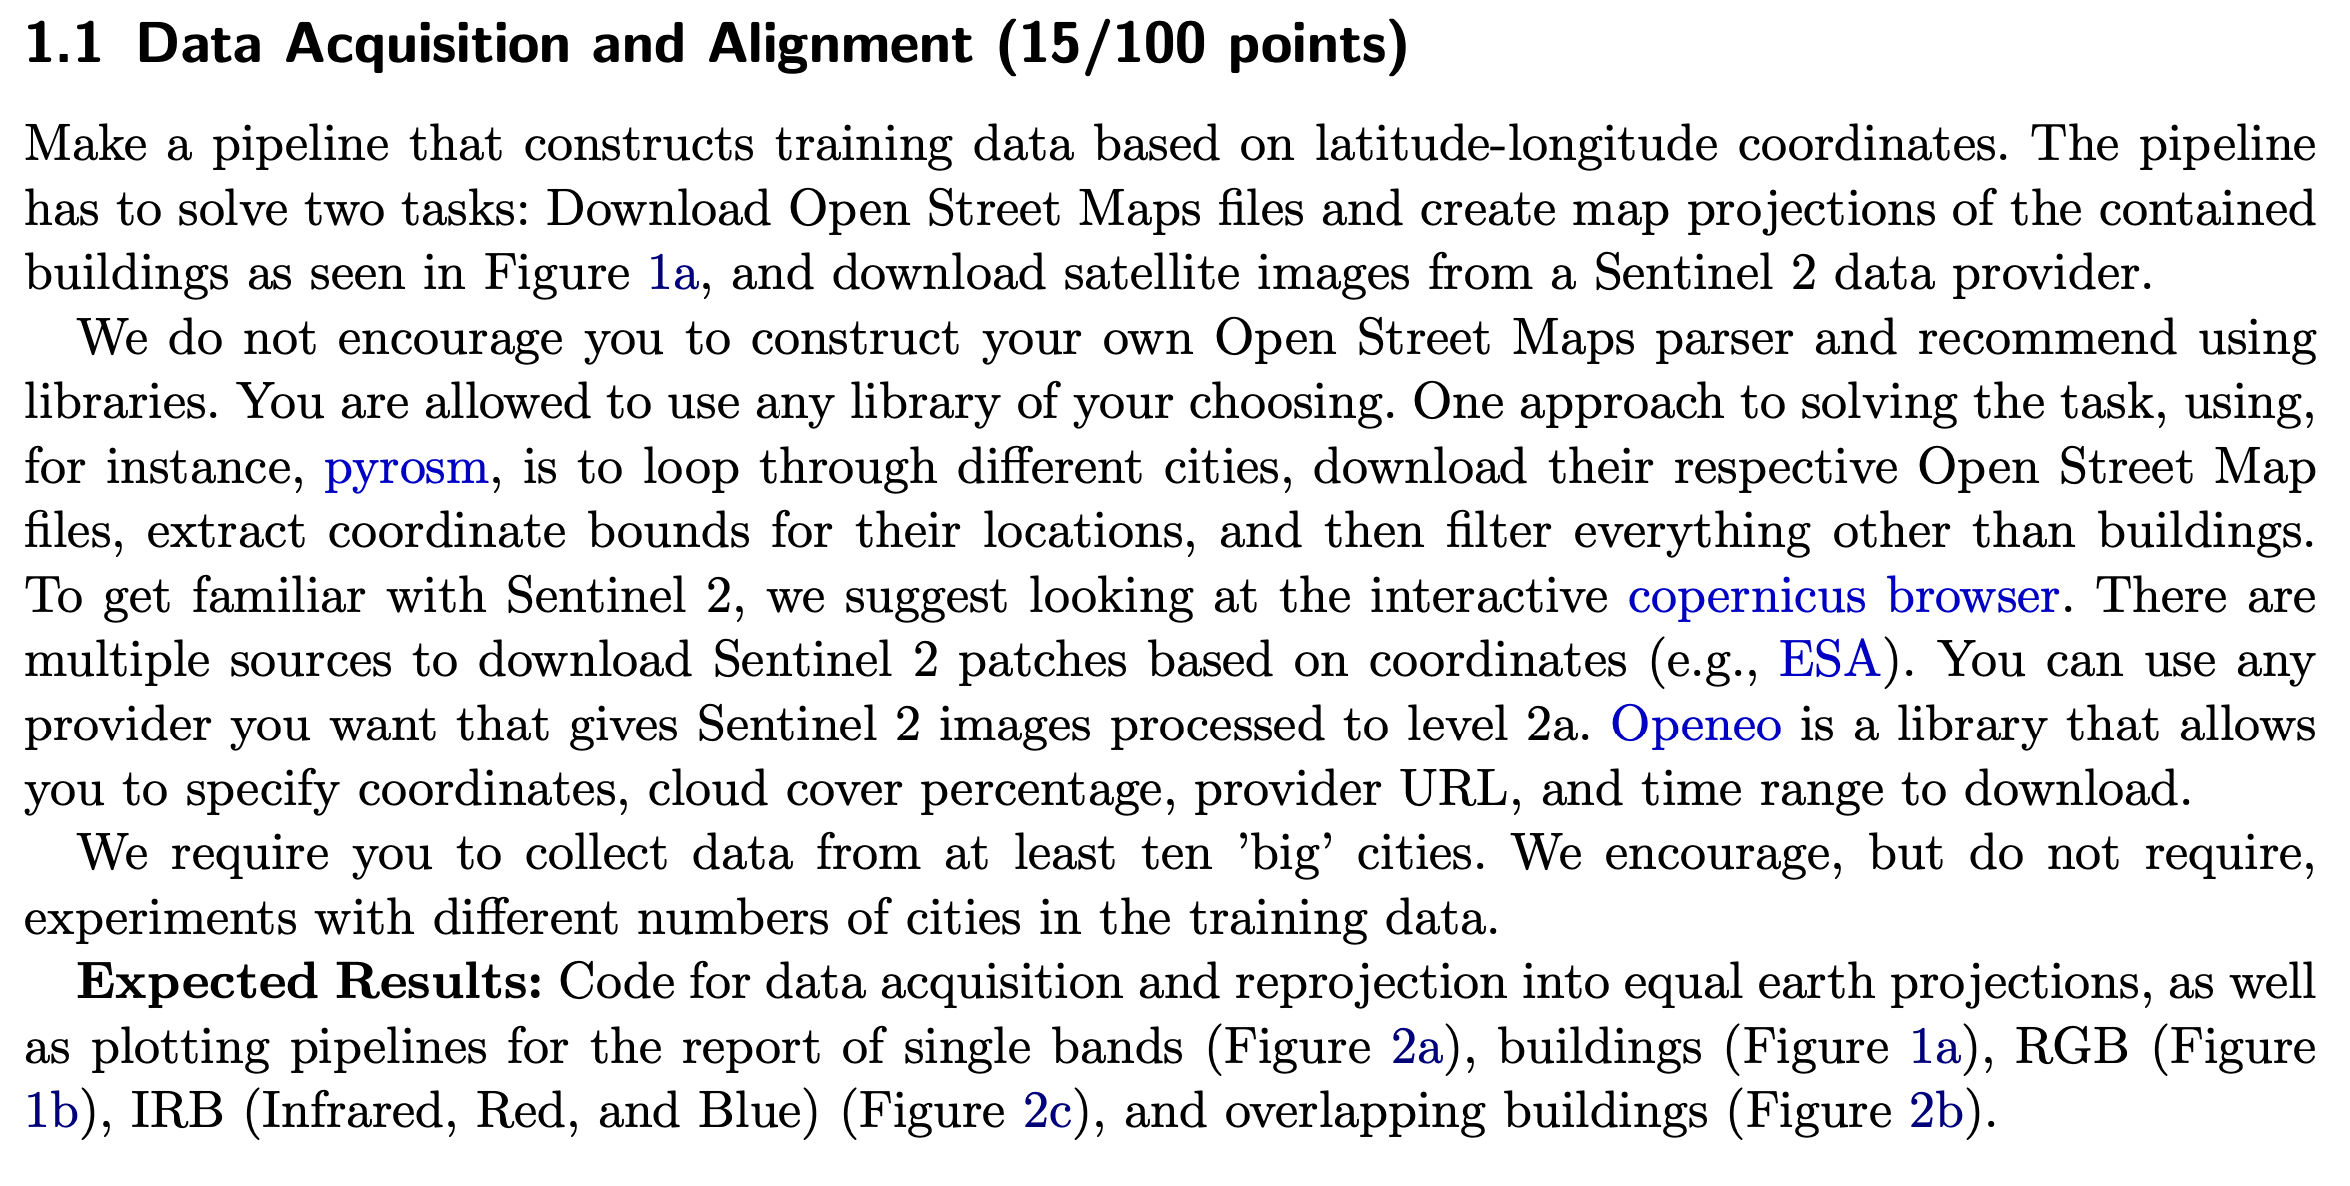

**1. Data acquisition: Download the Open streetmaps files.**

we could use pyrosm

In [ ]:
import pyrosm
from io import BytesIO
import openeo
import os

import xarray
import matplotlib.pyplot as plt
import numpy as np
import random
import tempfile
import io

from pathlib import Path
from PIL import Image

from rasterio.features import rasterize

import albumentations as A
from IPython.display import display
import cv2

In [ ]:
# Prepare local directories and file paths
resource_path = Path("ressources/")
resource_path.mkdir(parents=True, exist_ok=True)

osm_data_fp = resource_path / "osm_maps/"
osm_data_fp.mkdir(parents=True, exist_ok=True)

sattelite_images = resource_path / "sattelite_images/"
sattelite_images.mkdir(parents=True, exist_ok=True)

dev_mode_osm_fp = osm_data_fp / "Berlin.osm.pbf"

dev_sat_img_fp = sattelite_images / "composite_sattelite_image.nc"

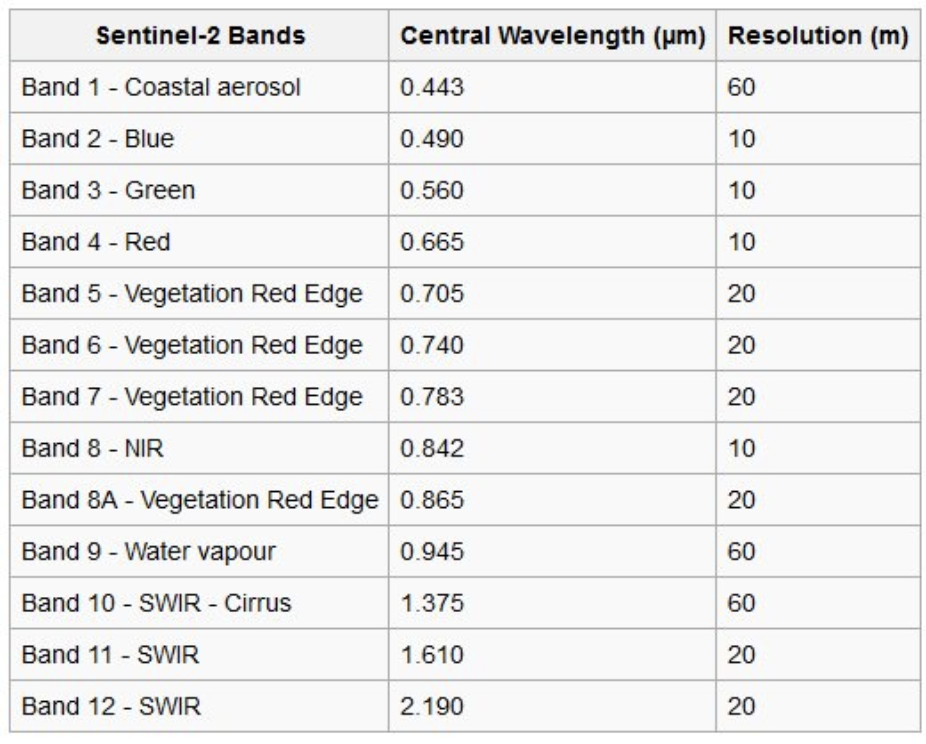

In [ ]:
class Config:
    # Sattelite Related
    sentinel_2_connection_id="SENTINEL2_L2A" # Sentinel data we are dealing with
    rgb_bands = ["B04", "B03", "B02"] # Bands we are working with
    irb_bands = ["B08","B04", "B02"]
    single_band = ["B08"]
    all_bands = rgb_bands + irb_bands
    
    # OSM Related
    MIN_NUMBER_OF_CITIES = 1

    # Feel free to add cities to this list.
    HANDPICKED_CITIES = ["London", "Moscow", "Istanbul", "Paris", "Madrid", "Manchester",
              "Barcelona", "Copenhagen", "Hamburg", "Warsaw"]
    # TODO change back to all cities
    cities = [HANDPICKED_CITIES[0]] # just using the first one for development purposes. At the end we will use all cities.
    fps = []
    
    # Training Related
    patch_size = 32
    height = 1024 # Resolution in the y direction
    width = 1024 # Resolution in the x direction
    channel_amount = 4
    
    # Coordinate related W, S, E, N (min lng, min lat, max lng, max lat)
    accuracy_test_coordinates = [13.294333, 52.454927, 13.500205, 52.574409] # Berlin test data coordinates
    city_coords = [] # initialized later
    
    # Temp
    demo_coordinates = accuracy_test_coordinates # Developing demo coordinates
    demo_city_index = 0 # or by using a demo index for one of the 10 cities
    temp_city = "Berlin" # Example
        
config = Config()

In [ ]:
def check_if_file_already_exists(fp):
    if os.path.isfile(fp):
        fp = str(fp)
        return fp
    else:
        return False

In [ ]:
expected_shape = (config.width, config.height, config.channel_amount)

def check_np_image_size(img: np.ndarray) -> None:
    assert img.shape == expected_shape

In [ ]:
# Function to download the OSM data and return the filepath
def get_city_data(city_name: str, save_locally = False):

    # If the file exists in ressources no need to download it again.
    osm_city_local_file_path = osm_data_fp / str(city_name + ".osm.pbf")

    fp = check_if_file_already_exists(fp = osm_city_local_file_path)
    # only downloading if the file doesn't already exist in backend
    if not fp:
        fp = pyrosm.get_data(city_name)

    return fp

In [ ]:
# Lets make sure we have all the files for the cities we are working with
# Download does take a little while
# if already saved please set save_locally to False
config.fps = []
for city in config.cities:
    print("downloading city data: ", city)
    config.fps.append(get_city_data(city,save_locally=True))

print("config.fps: ", config.fps)

In [ ]:
# Manually searched Coordinates for the ten default cities ONLY!!
ALL_HANDPICKED_CITY_COORDS = [
    [-0.224136,51.425376,0.023057,51.547662],
    [37.502643,55.692206,37.737476,55.814364],
    [28.878773,40.982672,29.075326,41.078498],
    [2.250884,48.815576,2.428039,48.90637],
    [-3.795446,40.361223,-3.605588,40.48302],
    [-2.357444,53.420581,-2.140121,53.540919],
    [2.052497,41.317035,2.228355,41.467914],
    [12.459183,55.644274,12.637024,55.724790],
    [9.902096,53.515476,10.081997,53.605835],
    [20.910186,52.175346,21.097983,52.270619]
]

city_coords = [ALL_HANDPICKED_CITY_COORDS[0]]

In [ ]:
# We need the administrative coordinates for each of the cities we picked
# The issue is that the resolution is based off of the size of the area we pick
# So we need need to get the original bounding box then minimize it to something
# That is close to our coordinates to avoid having to crop most of it out
def get_coords(idx, zoom = 1):
    # Proper way of doing it if you have a lot of ram
    # This method loads the entire fp into memory without filter thus it crashes the notebook
    # coords = pyrosm.OSM(config.fps[idx]).get_boundaries(boundary_type='administrative')
    
    # Manually collected coordinates as an alternative
    coords = city_coords[idx]
    return zoomin(coords,zoom) # Only if you want to disable this function's Resolution matching
    
#     center = [(coords[2]-coords[0])/2.0 +coords[0], (coords[3]-coords[1])/2.0 + coords[1]]
    
    #Using the inverse of Harversine formula (for our case)
#     lat_dist = (config.height*10)/(2*6371e3)
#     cos_term = math.cos(center[1])**2
#     tan_term = math.tan((config.width*10)/(2*6371e3))**2
#     lng_dist = math.asin((cos_term/tan_term + cos_term)**0.5/(cos_term/tan_term + cos_term))
    
    # Approximation
#     lng_dist = (config.width) / (40075000 *(math.cos(coords[1])/360) * zoom)
#     lat_dist = (config.height*5) / 111320 / zoom

#     return [center[0]-lng_dist, center[1]-lat_dist, center[0]+lng_dist, center[1]+lat_dist]


# Extra function to just Zoom in instead of calculating resolution results
def zoomin(coords,zoom):
    lng = (coords[2]-coords[0])/(2*zoom)
    lat = (coords[3]-coords[1])/(2*zoom)
    center = [(coords[2]-coords[0])/2.0 +coords[0], (coords[3]-coords[1])/2.0 + coords[1]]
    return [center[0]-lng, center[1]-lat, center[0]+lng, center[1]+lat]

In [ ]:
config.city_coords = []
for i in range(config.MIN_NUMBER_OF_CITIES):
    config.city_coords.append(get_coords(i))

In [ ]:
# Function to get building data of our cities according to our new adjusted bounding box
# TODO find a way to speed this up
# TODO save the building data locally as well.
def get_buildings(city_data_fp,bounding_box):
    osm = pyrosm.OSM(city_data_fp, bounding_box)
    return osm.get_buildings().to_crs(4326)

# Function used for plotting and saving things in a buffer for development
def get_buildings_buffer(city_data_fp, bounding_box):
    print("extracting buildings. This can take up to a minute or two. Be patient")
    buildings = get_buildings(city_data_fp,bounding_box)
    fig = plt.figure(frameon=False)
    buildings.plot()
    plt.axis('off')

    # Save to in-memory buffer
    file_buffer = BytesIO()

    # TODO what about the amount of pixels? image size? Check when we have the Neural Network.
    fig.savefig(file_buffer, format='png', bbox_inches='tight',transparent=True, pad_inches=0)

    return file_buffer

In [ ]:
print(config.fps[config.demo_city_index])
print(config.city_coords[config.demo_city_index])
building_buffer = get_buildings_buffer(config.fps[config.demo_city_index], config.city_coords[config.demo_city_index])
image = Image.open(io.BytesIO(building_buffer.getvalue()))
building_buffer.close()

In order to be able to manipulate the image we need to be able to rasterize it first

In [ ]:
# Uses a lot of memory depending on the resolution (height/width), lower it if it crashes
def rasterize_osm(fp, coords, height=config.height, width=config.width):
    print("this can take up to a minute or two")
    buildings = get_buildings(fp,coords)
    xres = (coords[2] - coords[0]) / width
    yres = (coords[3] - coords[1]) / height
    # Affine transformation
#     | x' |   | a  b  c | | x |
#     | y' | = | d  e  f | | y |
#     | 1  |   | 0  0  1 | | 1 |
    return rasterize(shapes=buildings.geometry,
                     out_shape=(height, width),
                     transform=(xres, 0, coords[0], 0, -yres, coords[3]))
def plot_raster(img):
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
plot_raster(rasterize_osm(config.fps[config.demo_city_index], config.city_coords[config.demo_city_index]))

Let's connect to copernicus, really not that hard leon

In [ ]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")

# You will have to click on the displayed url in the output once first time you run the notebook
connection.authenticate_oidc()

In [ ]:
# Turning bounding box into WSEN dict
def get_spatial_extend(bounding_box):
    spatial_extend = {
    "west": bounding_box[0], 
    "south": bounding_box[1], 
    "east": bounding_box[2], 
    "north": bounding_box[3],
    "crs": "EPSG:4326",
    }
    return spatial_extend

In [ ]:
def approach1(city_index: int, coords, bands, start_date = "2023-04-01", end_date = "2023-08-30"):
    city = config.cities[city_index]
    bands_str = "_".join(bands)
    sattelite_img_fp = sattelite_images / str(city + bands_str + ".nc")
    if not check_if_file_already_exists(sattelite_img_fp):
        # Prepare the Query (Summer/Spring months, Long periods are preferred, low cloud coverage)
        s2_cube = connection.load_collection(
            "SENTINEL2_L2A",
            temporal_extent=(start_date, end_date),
            spatial_extent=get_spatial_extend(coords),
            bands=bands+["SCL"],
            max_cloud_cover=30,
        )
        # Mark which band we are using for masking
        scl_band = s2_cube.band("SCL")
        # Mask which pixel values we want replaced
        cloud_mask = (scl_band == 3) | (scl_band == 8) | (scl_band == 9)
        # Resample the resolution (because SCL is 20m res, not 10, it may create artifacts if we dont do this)
        cloud_mask = cloud_mask.resample_cube_spatial(s2_cube)
        # Mask our query and get the mean values
        composite_masked = s2_cube.mask(cloud_mask).mean_time()

        print("saving ", city, " with bands ", bands_str, " locally so that we don't have to redownload the sattelite data again.")
        composite_masked.download(outputfile=sattelite_img_fp)

    ds = xarray.load_dataset(sattelite_img_fp)
    # Convert xarray DataSet to a (bands, x, y) DataArray
    return ds[bands+["SCL"]].to_array(dim="bands")

In [ ]:
# TODO make approach 2 use locally saved data as well?
def approach2(coords, bands, save_spatial_data = False, start_date = "2023-08-01", end_date = "2023-09-30"):
    # Prepare the Query (Summer/Spring months, short periods are acceptable , any cloud coverage)
    s2_cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=(start_date, end_date),
    spatial_extent=get_spatial_extend(coords),
    bands=bands+["SCL"],
    max_cloud_cover=50,
    )
    
    # use if you need the data locally for some reason.
    # choose enough bands.
    if save_spatial_data:
        print("downloading the spatial data and saving it locally.")
        s2_cube.download(outputfile=dev_sat_img_fp)
    
    # Save to in-memory buffer
    with tempfile.NamedTemporaryFile(suffix=".nc") as tmpfile:
        print("downloading sattelite data. This may take a few minutes...")
        s2_cube.download(outputfile=tmpfile.name)
        print("download finished")

        ds = xarray.load_dataset(tmpfile.name)
        # Convert to Data array
        time_data = ds[bands+["SCL"]].to_array(dim="bands")
        # Variables to save least cloudy day
        min_clouds = float('inf')
        min_index = 0

        for i,inst in enumerate(time_data[3]):
            # Count SCL classes
            indices,counts = np.unique(inst.data,return_counts=True)

            curr = dict(zip(indices, counts))
            # Count cloudy pixels
            cld_small = curr.get(8)
            cld_big = curr.get(9)
            cld_shadow = curr.get(3)
            # Sum up cloudy pixels
            curr_clouds = cld_small if cld_small else 0 + cld_big if cld_big else 0 + cld_shadow if cld_shadow else 0
            # Save minimum cloudyness
            if(curr_clouds<min_clouds):
                min_clouds=curr_clouds
                min_index=i
            if(min_clouds==0): break
        # Save least cloudy day
        return time_data[:,i,...]

In [ ]:
def get_spatial_data(city_index : int, coords, bands, approach=True, save_spatial_data = False):
    if approach:
        return approach1(city_index, coords,bands)
    else:
        return approach2(coords,bands,save_spatial_data)

In [ ]:
def get_spatial_image(data, bands):
    # handle single band images
    fig, ax = plt.subplots()
    plt.axis('off')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())  # Removes padding
    plt.gca().yaxis.set_major_locator(plt.NullLocator())  # Removes padding
    if len(bands) == 1:
        data[0].plot.imshow(vmin=0, vmax=2000, ax=ax, cmap='Greys',  interpolation='bilinear')
    else:
        data[0:3].plot.imshow(vmin=0, vmax=2000, ax=ax)

    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)

    plt.close(fig)
    # data.plot.imshow(vmin=0, vmax=2000)

    return buf

In [ ]:
def display_sattelite_image(data, bands):
    print("generating spatial image")
    satt_image_buf = get_spatial_image(data, bands = bands)
    sattelite_image = Image.open(io.BytesIO(satt_image_buf.getvalue()))
    display(sattelite_image)
    satt_image_buf.close()

### RGB SATTELITE IMAGE

In [ ]:
# Run this with save_spatial_data = True to save the spacial data locally.
display_sattelite_image(get_spatial_data(config.demo_city_index, config.city_coords[config.demo_city_index],
                                         config.rgb_bands,
                                         save_spatial_data=True),
                        bands=config.rgb_bands)

### IRB SATTELITE IMAGE

In [ ]:
display_sattelite_image(get_spatial_data(config.demo_city_index, config.city_coords[config.demo_city_index],
                                         config.irb_bands),
                        bands=config.irb_bands)

### SINGLE BAND SATTELITE IMAGE

In [ ]:
# TODO we want only the image nothing else.
# TODO figure out for what single bands are even used?
display_sattelite_image(get_spatial_data(config.demo_city_index, config.city_coords[config.demo_city_index],
                                         config.single_band),
                        bands=['SCL'])

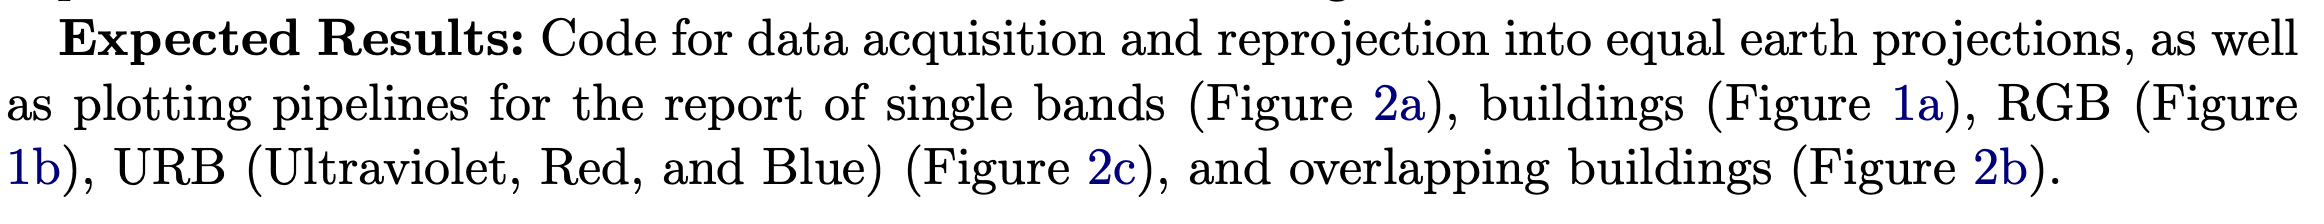

## 1.2 Data Preparation
- Training (Sattelite) images from Task 1.1 are given in an xarray Dataset of shape [Bands, Height, Width] per image, but also associated with it are variable spatial coordinates.
    - Bands dictating which bands we used
    - X dictating the spatial longitude coordinates of our PixelX
    - Y dictating the spatial latitude coordinates of our PixelY
- Osm data are given as a 2d raster numpy array (pixel_x, pixel_y)

#### Task:
1. Given the pipeline from Task 1.1, prepare the large images for training by slicing out tensors containing smaller training images of equal width and height, for instance, 32, 64, or 128 pixels

2.  include in the pipeline a simple cloud-cover classifier and remove all patches containing clouds.

3. Divide the data into train/validation/test sets of similar data distributions (e.g., label distribution and potentially other properties such as visual similarity or data provenance

**We need to make sure that the pixels properly align between the OSM data and the S2 data!**

In [ ]:
def sliceTensors(data, res=config.patch_size):
    # Generate patches from a regular grid
    min_w = data.shape[1]
    min_h = data.shape[2]

    # If the length dimension does not match a regular subdivision of grids, clip the start of it
    if(min_w%res!=0):
        min_w -= int(min_w - np.floor(min_w/res)*res)
    # If the width dimension does not match a regular subdivision of grids, clip the start of it
    if(min_h%res!=0):
        min_h -= int(min_h - np.floor(min_h/res)*res)
    data = data[:,:min_w,:min_h]
    #print(data.shape)

    # This is the proper way of doing it with numpy, but turning the array into a numpy array 
    # Makes the images wrong for some reason so lets find a way to keep them in Datarray
    # data.data.reshape((-1, min_w//res, res,min_h//res,res)).transpose(1,3,0,2,4).reshape(-1,data.shape[0],res,res)

    # This method is probably less efficient but it is easily correctly plottable by our function
    #[data[:,i*res:(i+1)*res,j*res:(j+1)*res] for i in range(data.shape[1]//res) for j in range(data.shape[2]//res)]

    # Best way I could find doing it while avoiding loops, its no numpy but its decent
    # We basically use a coarsen object to make Blocks of res x res size, call those dimensions as Nx and Ny
    # then stack them as one dimension and transpose it to the front
    return data.coarsen(x=res,y=res).construct(x=('Nx', 'x'),
                                               y=('Ny', 'y')).stack(N=['Nx',
                                                                       'Ny']).transpose('N','bands','x','y')

In [ ]:
def overlap_sattelite_with_osm_buildings(s2,osm,highlight=2):
    for i in {0,1,2}:
        if i==highlight:
            s2[i] += osm*np.max(s2[i]).data
        else:
            s2[i] -= osm*np.max(s2[i]).data
    return s2

In [ ]:
# Function that takes in a patch and returns if that patch is cloudy according to a precentage.
def cloud_patch(data,precent):
    img = np.array(data)
    p = (np.where((img==1) + (img==2) + (img==8) + (img==9))[0].shape[0] / img.shape[0]**2)
    #if(p>precent): print("Cloud precentage is :",p)
    return p>precent

# Removed cloudy patches from our data
# Harmless but non-beneficial if used with approach1
# Useful only if we use approach2
def cloudless_img(data,precent=0.02):
    n=data.shape[0]
    for i in range(n):
        if(i==data.shape[0]): break
        if cloud_patch(data[i,3],precent):
            data = np.delete(data,i,axis=0)
    #print("Deleted ",n-data.shape[0], " cloudy patches")
    return (np.array(data[:,0:3]), data.shape[0])

In [ ]:
## Visual Example over 1 city
# temp_coords = get_coords(9)
# temp_fp = config.fps[9]

# example_s2 = get_spatial_data(temp_coords, config.rgb_bands)

# example_osm = rasterize_osm(temp_fp, temp_coords, example_s2.shape[1],example_s2.shape[2])

# print(example_s2.shape, example_osm.shape)
# display_sattelite_image(example_s2, config.rgb_bands)
# plot_raster(example_osm)

# combined = highlight(example_s2,example_osm)
# display_sattelite_image(combined, config.rgb_bands)

# sliced_s2 = sliceTensors(example_s2,res=64)
# sliced_combined = sliceTensors(combined,res=64)

# fig, ax = plt.subplots()
# plt.axis('off')
# plt.gca().xaxis.set_major_locator(plt.NullLocator())  # Removes padding
# plt.gca().yaxis.set_major_locator(plt.NullLocator())  # Removes padding

# sliced_s2[55,0:3].plot.imshow(vmin=0, vmax=2000, ax=ax)
# sliced_combined[55,0:3].plot.imshow(vmin=0, vmax=2000, ax=ax)

# cloudless_example,temp = cloudless_img(sliced_s2)
# print(cloudless_example.shape)

In [ ]:
samples = []
count = 0
limit = 0
# Iterate over citites
for city_index, (c,f) in enumerate(zip(config.city_coords,config.fps)):
#     if (limit==2): break;
    # Name the city
    name = f.split('/')[-1].split('.')[0]
    print("Processing data for", name)
    
    # Fetching data
    s2 = get_spatial_data(city_index, c, config.rgb_bands)
    osm = rasterize_osm(f, c, s2.shape[1],s2.shape[2])
    
    # Highlighting building pixels
    full_target = overlap_sattelite_with_osm_buildings(s2,osm)
    
    # Patching the data into many
    sliced_x = sliceTensors(s2)
    print("Created ", sliced_x.shape[0], " patches from this image")
    sliced_y = sliceTensors(full_target)
    
    if (limit==0):
        X,temp = cloudless_img(sliced_x)
        y,__ = cloudless_img(sliced_y)
        print("Removed ", sliced_x.shape[0]-temp, " potentially cloudy patches")
        samples.append(count)
        count+=temp
        limit+=1
        continue
    
    cld_x,temp = cloudless_img(sliced_x)
    cld_y,__ = cloudless_img(sliced_y)
    X = np.concatenate((X,cld_x),axis=0)
    y = np.concatenate((y,cld_y),axis=0)
    samples.append(count)
    count+=temp
    limit+=1

In [ ]:
def train_val_test_split(X, y, indices, val=0.1, test=0.2):
    test_indices = []
    val_indices = []
    ratio = val/(test+val)
    # Generating random indices of validation and test per city
    # we dont want one city to dominate Train/Test/Val subset
    for i in range(1,config.MIN_NUMBER_OF_CITIES):
        # Total number per distribution per city
        total = indices[i]-indices[i-1]
        val_n = int(val*total)
        test_n = int(test*total)
        total = total - val_n - val_n
        # Sample indices randomly
        total_indices = random.sample(range(indices[i-1],indices[i]),val_n+test_n)
        split = int(ratio*(val_n+test_n))
        val_indices = np.concatenate((val_indices,total_indices[:split]))
        test_indices = np.concatenate((test_indices,total_indices[split:]))
    
    val_indices = np.array(val_indices, dtype=int)
    test_indices = np.array(test_indices, dtype=int)
    
    val_X = np.take(X,val_indices,axis=0)
    val_y = np.take(y,val_indices,axis=0)
    
    test_X = np.take(X,test_indices,axis=0)
    test_y = np.take(y,test_indices,axis=0)
    
    remove = np.concatenate((val_indices,test_indices))
    train_X = np.delete(X,remove,axis=0)
    train_y = np.delete(y,remove,axis=0)
                            
    return (train_X, train_y, val_X, val_y, test_X, test_y)

In [ ]:
train_X, train_y, val_X, val_y, test_X, test_y = train_val_test_split(X,y,samples)
print(X.shape, y.shape)
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

Expected Results: Code for data preparation of disjoint train, validation, and test data with
similar distributions of statistics. The report should justify the chosen selection procedure and how it
preserves the similarity of specific properties

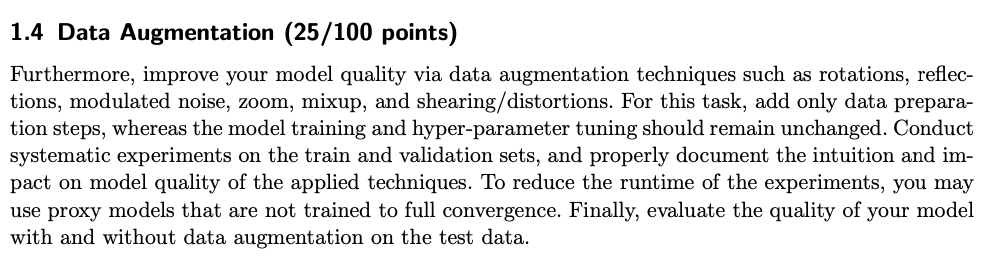

I will now write functions which provide the data augmentation functionality. Doing this before 1.3, because we can probably train with and without the augmented data immediately if we include the data augmentation functions into the pipeline.